# Temperature Forecasting in Tetouan City
**Coded by**: [Krisna Santosa](https://www.dicoding.com/users/krisna_santosa/)

**Dataset from**: [UC Irvine Machine Learning Repository: Power Consumption of Tetouan city](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city)

## Preparation

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Make dataset as dataframe
data_train = pd.read_csv("TetouanCity.csv")
data_train

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [3]:
# Check is dataframe has missing value?
data_train.isnull().sum()

DateTime                     0
Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

## Data Preprocessing

In [4]:
# Get Features From Dataset
dates = data_train['DateTime'].values
temp = data_train['Temperature'].values

Showing 15K data points on the middle of distribution data.
Total data is: 52416

Text(0.5, 1.0, 'Temperature per 10 minutes (Middle 15,000 Data Points)')

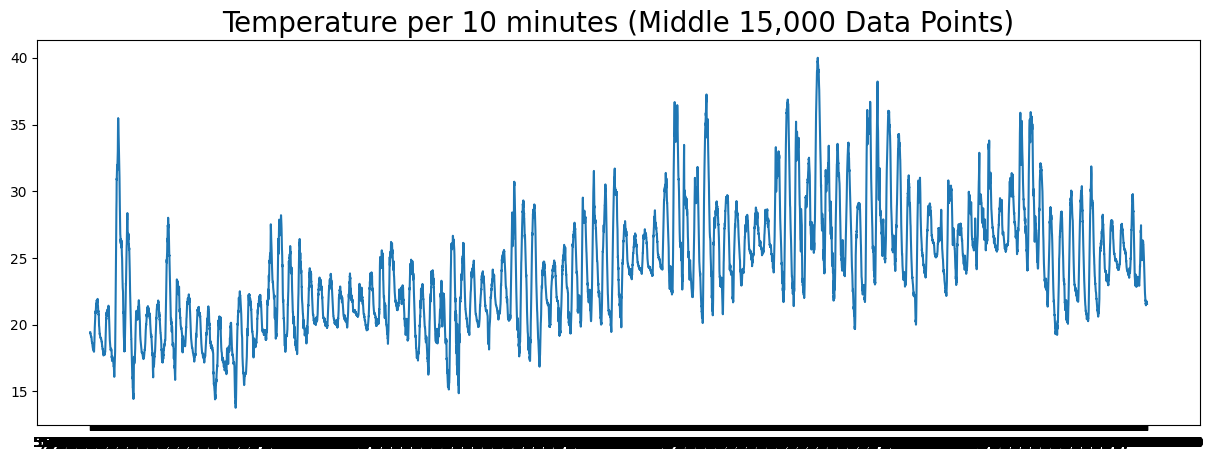

In [16]:
# Calculate the middle index
middle_index = len(temp) // 2

num_showing_data = 15000 # all data is: 52416

# Plotting the middle 15,000 data points
plt.figure(figsize=(15, 5))
plt.plot(dates[middle_index - num_showing_data // 2: middle_index + num_showing_data // 2], temp[middle_index - num_showing_data // 2: middle_index + num_showing_data // 2])
plt.title('Temperature per 10 minutes (Middle 15,000 Data Points)', fontsize=20)

In [6]:
# Make the data range between -1 to 1
min_max_scaler = preprocessing.MinMaxScaler()
temp_scaled = min_max_scaler.fit_transform(temp.reshape(-1, 1))
temp_scaled

array([[0.09009058],
       [0.0861464 ],
       [0.08339907],
       ...,
       [0.09936621],
       [0.09550363],
       [0.09066181]])

In [7]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(temp_scaled[:-1], temp_scaled[1:], test_size=0.2, shuffle=False)
print("X train count: ",len(X_train))
print("Y train count: ",len(y_train))
print("X test count: ",len(X_test))
print("Y test count: ",len(y_test))

X train count:  41932
Y train count:  41932
X test count:  10483
Y test count:  10483


In [8]:
# Convert dataframe to dataseries for feeding the model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

## Training Model

In [9]:
# Build Architecture Model
train_set = windowed_dataset(series=X_train, window_size=256, batch_size=256, shuffle_buffer=1024)
val_set = windowed_dataset(series=X_test, window_size=256, batch_size=256, shuffle_buffer=1024)

model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), input_shape=(256, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [10]:
# treshold must be < 10% of the range data
threshold_mae = (temp_scaled.max() - temp_scaled.min()) * 0.10
print(f"The threshold is: {threshold_mae}")

The threshold is: 0.1


In [11]:
# Make a custom callback for threshold, monitor the MAE
class MAEThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MAEThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_mae = logs.get('mae')
        current_val_mae = logs.get('val_mae')

        if current_mae is not None and current_val_mae is not None:
            if current_mae < self.threshold and current_val_mae < self.threshold:
                print(f"\n[PASS] Training MAE ({current_mae:.4f}) and Validation MAE ({current_val_mae:.4f}) are below the threshold. Stopping training.")
                self.model.stop_training = True
            else:
                print(f"\n[FAIL] Training MAE ({current_mae:.4f}) or Validation MAE ({current_val_mae:.4f}) is above or equal to the threshold.")

# Define Callbacks (ModelCheckpoint, EarlyStopping, MAEThreshold)
checkpoint = ModelCheckpoint("best_model.h5", monitor="mae", save_best_only=True, mode="min")
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
mae_threshold_callback = MAEThresholdCallback(threshold=threshold_mae)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.0e-4,
    decay_steps=10000,
    decay_rate=0.96
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256, 512)          528384    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [12]:
# Train Model with Callbacks
history = model.fit(
    train_set,
    epochs=25,
    validation_data=val_set,
    callbacks=[checkpoint, early_stopping, mae_threshold_callback]
)

Epoch 1/25
    163/Unknown - 46s 226ms/step - loss: 0.0180 - mae: 0.1566
[FAIL] Training MAE (0.1566) or Validation MAE (0.0982) is above or equal to the threshold.
163/163 [==============================] - 55s 279ms/step - loss: 0.0180 - mae: 0.1566 - val_loss: 0.0082 - val_mae: 0.0982
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - ETA: 0s - loss: 0.0057 - mae: 0.0825
[PASS] Training MAE (0.0825) and Validation MAE (0.0952) are below the threshold. Stopping training.
163/163 [==============================] - 44s 269ms/step - loss: 0.0057 - mae: 0.0825 - val_loss: 0.0077 - val_mae: 0.0952


## Monitoring The Model

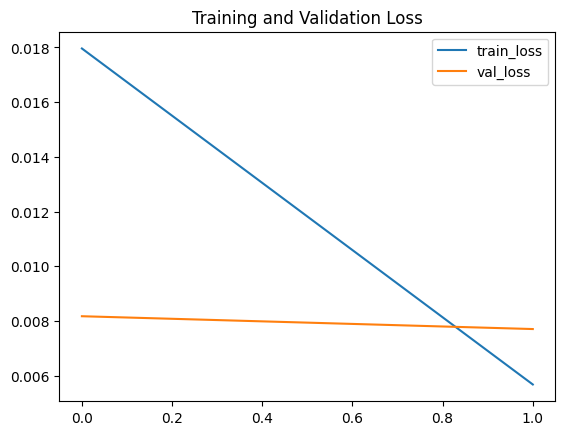

In [13]:
# Plotting Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

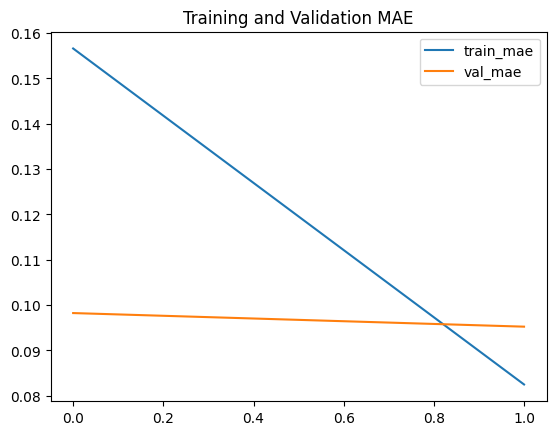

In [14]:
# Plotting Mae
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

In [15]:
if history.history['mae'][-1] < threshold_mae:
  print(f"The model is acceptable, cuz mae < 10% i.e {history.history['mae'][-1]} < {threshold_mae}")
else:
  print(f"The model is not acceptable, cuz mae >= 10% i.e {history.history['mae'][-1]} >= {threshold_mae}")

The model is acceptable, cuz mae < 10% i.e 0.082478366792202 < 0.1
